## Using Remote Sensing to Predict and Understand Future Wildfires
### by Zeynep Ankut, Isaiah Stene, Corey Becker

In [112]:
#dummy comment for change to push with

Does the needed imports and downloads the dataset (takes like 5 minutes)

In [113]:
import importFunctions as imp 
import kagglehub

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from matplotlib import colors
import matplotlib.pyplot as plt
import numpy as np

from sklearn.utils.class_weight import compute_class_weight

import pandas as pd


path = kagglehub.dataset_download("fantineh/next-day-wildfire-spread")
print("Path to dataset files:", path)

train_files = path + "/next_day_wildfire_spread_train*"
test_files = path + "/next_day_wildfire_spread_test*"
eval_files = path + "/next_day_wildfire_spread_eval*"


train = imp.get_dataset(train_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

test = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)


eval_data = imp.get_dataset(test_files,  
      data_size=64,
      sample_size=32,
      batch_size=100,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=False,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

Path to dataset files: C:\Users\theco\.cache\kagglehub\datasets\fantineh\next-day-wildfire-spread\versions\2


In [114]:
def plotRows(start,end,titles,n_features,data):
  inputs, labels = next(iter(data))

  fig = plt.figure(figsize=(15,6.5))

  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  n_rows = end-start
  for i in range(n_rows):
    for j in range(n_features + 1):
      plt.subplot(n_rows, n_features + 1, i * (n_features + 1) + j + 1)
      if i == 0:
        plt.title(titles[j], fontsize=13)
      if j < n_features - 1:
        plt.imshow(inputs[i+start, :, :, j], cmap='viridis')
      if j == n_features - 1:
        plt.imshow(inputs[i+start, :, :, -1], cmap=CMAP, norm=NORM)
      if j == n_features:
        plt.imshow(labels[i+start, :, :, 0], cmap=CMAP, norm=NORM) 
      plt.axis('off')
  plt.tight_layout()

  plt.show()

In [115]:
titles = [
  'Elevation',
  'Wind\ndirection',
  'Wind\nvelocity',
  'Min\ntemp',
  'Max\ntemp',
  'Humidity',
  'Precip',
  'Drought',
  'Vegetation',
  'Population\ndensity',
  'Energy\nrelease\ncomponent',
  'Previous\nfire\nmask',
  'Fire\nmask'
]

# plotRows(20,25,titles,len(titles)-1, train)

In [116]:
inputs, labels = next(iter(train))


#now get select features
# indices = [1, 2, 3, 4, 5, 6, 10]
# tf.gather(inputs, indices, axis=-1)

# # print(labels.shape)

# n_fires, height,width, feat_images = inputs.shape

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, feat_images)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dense(3)) # there are 3 outputs: fire, no fire, and no data

# model.summary()

In [117]:

#this is very big, takes a looooooong time to do all epochs. Can crash computer btw.
def build_segmentation_cnn(height,width, features, num_classes):
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(height, width, features)),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        layers.Dropout(0.2),  # After pooling or dense layers


        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),


        # adds new convolution layers with dilation rates above 1, which is spacing between kernels
        layers.Conv2D(128, (3, 3), dilation_rate=2, padding='same', activation='relu'),
        layers.Conv2D(256, (3, 3), dilation_rate=4, padding='same', activation='relu'),
        
        # layers.Conv2DTranspose(128, (3, 3), padding='same', activation='relu'),
        # layers.Conv2DTranspose(64, (3, 3), padding='same', activation='relu'),

        layers.Conv2D(1, (1, 1), activation='sigmoid')
    ])
    return model

def shift_data(labels):
    return tf.maximum(labels,tf.constant([0.]))
        
import tensorflow.keras.backend as K
  
def focal_loss(alpha=0.5, gamma=3.0):
    def loss(y_true, y_pred):
        y_pred = K.clip(y_pred, 1e-7, 1.0 - 1e-7)
        loss = -alpha * (1 - y_pred) ** gamma * y_true * K.log(y_pred) \
               - (1 - alpha) * y_pred ** gamma * (1 - y_true) * K.log(1 - y_pred)
        return K.mean(loss)
    return loss

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)


def weighted_bce(pos_weight=5.0):
    def loss(y_true, y_pred):
        if y_true.shape.rank < y_pred.shape.rank:
            y_true = tf.expand_dims(y_true, axis=-1)

            
        bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
        weights = 1. + (pos_weight - 1.) * y_true  # weight fire (1) more
        weights = tf.squeeze(weights, axis=-1) 
        return tf.reduce_mean(bce * weights)
    return loss

# def masked_loss(y_true, y_pred):
#     """Compute loss while ignoring -1 values."""
#     y_true = tf.squeeze(y_true, axis=-1)  # Remove extra dimension
#     mask = tf.not_equal(y_true, -1)  # Mask for valid labels
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')(y_true, y_pred)
#     return tf.reduce_mean(tf.boolean_mask(loss, mask))


In [118]:
n_fires, height,width, feat_images = inputs.shape

model = build_segmentation_cnn(height,width,feat_images,2)

labels = shift_data(labels)


c:\Users\theco\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [119]:
#new metric code
def precision_m(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    predicted_positives = tf.reduce_sum(y_pred)
    return true_positives / (predicted_positives + 1e-7)

def recall_m(y_true, y_pred):
    y_pred = tf.round(y_pred)
    true_positives = tf.reduce_sum(y_true * y_pred)
    possible_positives = tf.reduce_sum(y_true)
    return true_positives / (possible_positives + 1e-7)

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * (precision * recall) / (precision + recall + 1e-7)


In [120]:

t_inputs, t_labels = next(iter(test))
e_inputs, e_labels = next(iter(eval_data))

t_labels = shift_data(t_labels)
e_labels = shift_data(e_labels)

# tf.gather(t_inputs, indices, axis=-1)
# tf.gather(e_inputs, indices, axis=-1)

model.compile(optimizer='adam',
              loss= weighted_bce(pos_weight=10.0),
              metrics=['accuracy', precision_m, recall_m, f1_m])

# class_weights = compute_class_weight("balanced", np.array([0, 1]), y=np.array(labels).flatten())
# class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

history = model.fit(inputs, labels, epochs=10, 
    validation_data=(e_inputs, e_labels))




Epoch 1/10


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001F179321150>>
Traceback (most recent call last):
  File "C:\Users\theco\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5454 - f1_m: 0.0256 - loss: 0.9865 - precision_m: 0.0131 - recall_m: 0.4547 

This is a function to plot the results of the classification, it can plot the actual fire maps vs the predicted fire maps.

In [ ]:
def getPredMask(prediction):
  #this takes in the prediction and converts it into a binary image of 1's and 0's based on if the model had a higher probability of no fire (0) or fire (1)

  return np.argmax(prediction,axis=3)


def PlotPredictions(start,end,label,prediction):
  """
  plots pairs of images, one for the actual fire mask, and the next for the predicted firemask from our model.

  Args:
  start (int): the index of the first firemask to use
  end (int): the index of the last fire mask to use, non-inclusive
  label: the actual fire mask
  prediction: the predicted fire mask from the model
  """
    
  n_plots = end - start
  fig, axes = plt.subplots(n_plots, 3, figsize=(12, 4 * n_plots))
  # norm2 = colors.Normalize(vmin=0, vmax=1)  


  CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
  BOUNDS = [-1, -0.1, 0.001, 1]
  NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

  binPred = getPredMask(prediction)

  for i in range(n_plots):
    #actual fire mask
    axes[i,0].imshow(label[i+start,:,:,0],cmap=CMAP,norm=NORM)
    axes[i, 0].set_title(f"Actual Fire Mask {i + start} ")
    axes[i, 0].axis('off')

    #handles prediction, each prediction has a vector of [p_noFire,p_fire], we will use whatever one is larger
    axes[i,1].imshow(binPred[start+i,:,:],cmap=CMAP,norm=NORM)
    axes[i, 1].set_title(f"predicted Fire Mask {i + start}")
    axes[i, 1].axis('off')

    #this does the fire prob heat map
    img = axes[i, 2].imshow(prediction[start + i, :, :, 0], cmap='hot')
    axes[i, 2].set_title(f"Fire Probability Map {i + start}")
    axes[i, 2].axis('off')

    if i == 0:  
      cbar = plt.colorbar(img, ax=axes[0, 2], fraction=0.02, pad=0.04)
      cbar.set_label("Fire Probability")

  plt.tight_layout()
  plt.show()


4/4 - 2s - 485ms/step - accuracy: 0.9777 - f1_m: 0.0000e+00 - loss: 0.2828 - precision_m: 0.0000e+00 - recall_m: 0.0000e+00


ValueError: too many values to unpack (expected 2)

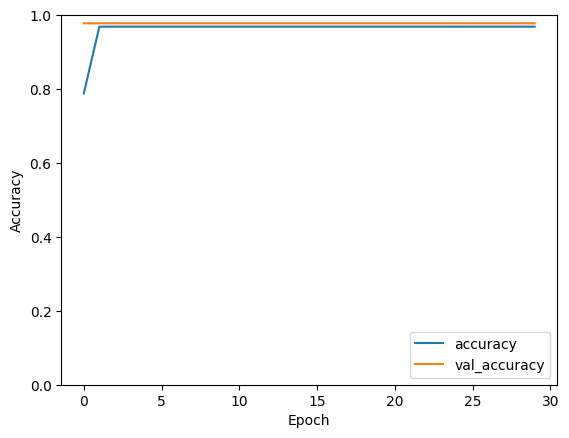

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(e_inputs,  e_labels, verbose=2)

print(test_acc)



t_loss, test_acc = model.evaluate(e_inputs, e_labels, verbose=2)
print(test_acc)

NEXT STEP: CHECK PREDICTIONS WITH PLOTS AND IMAGES! why is the accuaracy bad :(

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 464ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step


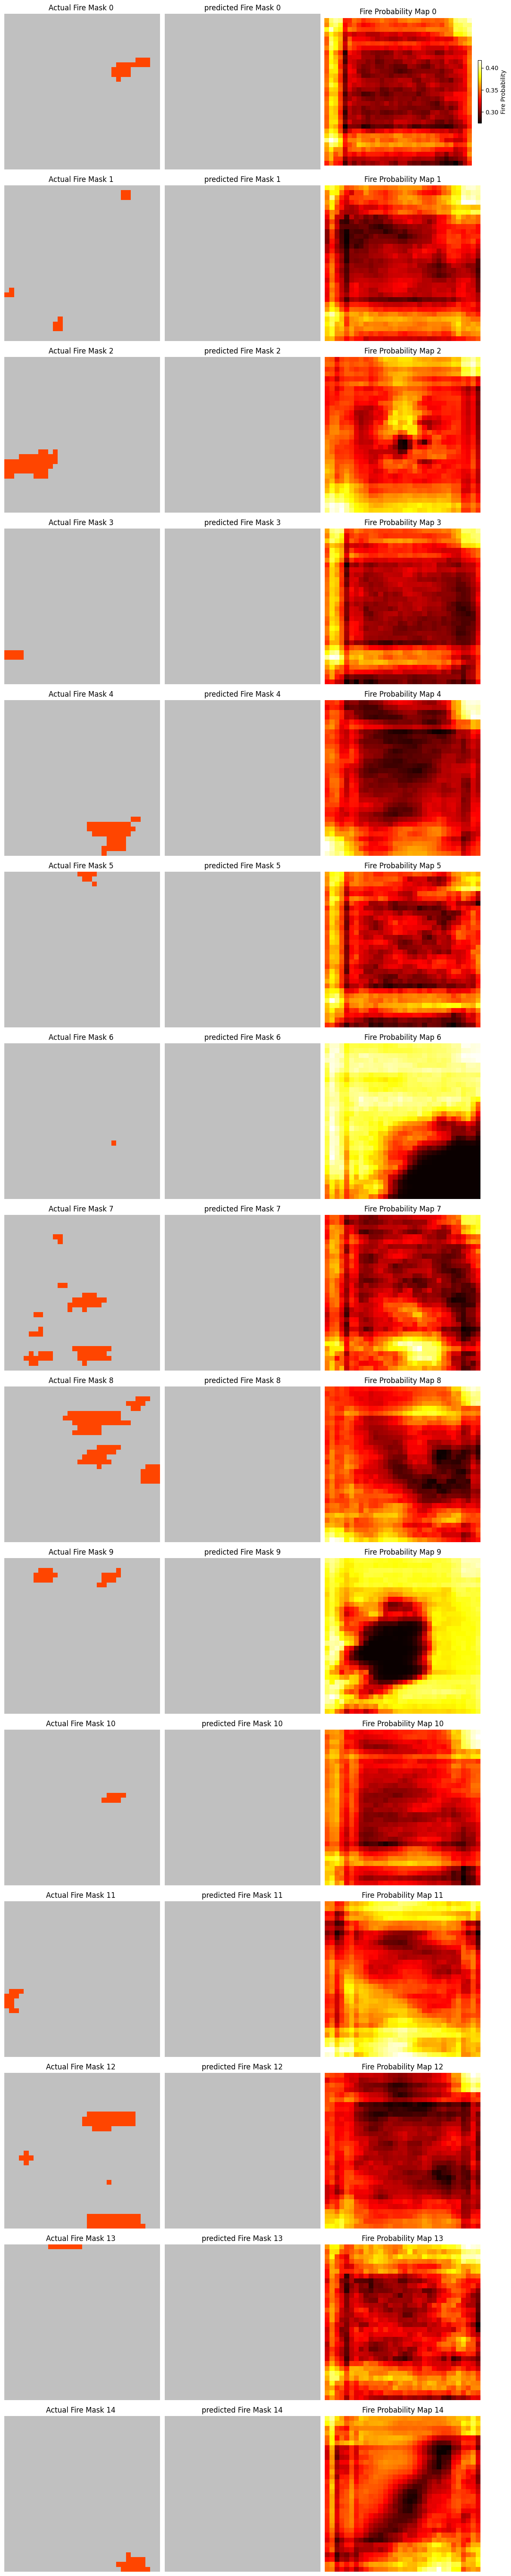

In [ ]:
pMask = model.predict(inputs)
pMask_eval = model.predict(e_inputs)


# plotRows(0,5,titles,len(titles)-1, train)
PlotPredictions(0,15,labels,pMask)